<a href="https://colab.research.google.com/github/remanx2558/MIDBReviews/blob/master/BERT_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install emoji 

In [0]:
!pip install emoji --upgrade

In [0]:
! pip install Cython --install-option="--no-cython-compile"

In [4]:
!pip install fasttext

In [5]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import emoji
import os
import time
import sys
import fasttext
import re
import nltk 
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
tf.keras.backend.clear_session()

import itertools
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#load data 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
train = pd.read_csv("/content/drive/My Drive/malia/train.csv")
train.head()

,text,sentiment
0,For a movie that gets no respect there sure ar...,0.0
1,Bizarre horror movie filled with famous faces ...,0.0
2,"A solid, if unremarkable film. Matthau, as Ein...",0.0
3,It's a strange feeling to sit alone in a theat...,0.0
4,"You probably all already know this by now, but...",0.0


In [7]:
test = pd.read_csv("/content/drive/My Drive/malia/test.csv")
test.head()



,text
0,This movie was horrible. If it had never been ...
1,The director infuses this film with false dept...
2,"I don't get it! The teenage leads in ""Horror S..."
3,"This is the fifth part of 'The Animatrix', a c..."
4,I was very impressed with with this film which...


In [0]:
train=train[['text','sentiment']]
#null_data = train[train.isnull().any(axis=1)] there is no null value in test set after removing the id, keyword, location column
test=test[['text']]


In [9]:

train.isnull().values.any()
train.sentiment= train.sentiment.fillna(0.0).astype(int)#this will conver float into int and also manage missing values

train.shape

(25005, 2)

In [10]:
# check class distribution in train dataset
from scipy import stats
train.groupby(['sentiment']).size()

sentiment
0    12505
1    12500
dtype: int64

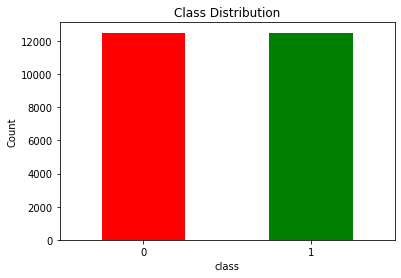

In [11]:
colors = list('rgb') #rgbkm
count_classes = pd.value_counts(train['sentiment'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color=colors, figsize=(6,4))
plt.title("Class Distribution")
plt.xlabel("class")
plt.ylabel("Count");

In [12]:
train.head()
train['text'].head()

0    For a movie that gets no respect there sure ar...
1    Bizarre horror movie filled with famous faces ...
2    A solid, if unremarkable film. Matthau, as Ein...
3    It's a strange feeling to sit alone in a theat...
4    You probably all already know this by now, but...
Name: text, dtype: object

In [0]:
#import contractions list and remove it in the next step
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [0]:
def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text


In [15]:
train['text']=train['text'].apply(remove_contractions)
train.tail()

,text,sentiment
25000,"My comments may be a bit of a spoiler, for wha...",1
25001,"The ""saucy"" misadventures of four au pairs who...",1
25002,"Oh, those Italians! Assuming that movies about...",1
25003,Eight academy nominations? It's beyond belief....,1
25004,"Not that I dislike childrens movies, but this ...",1


In [16]:
test['text']=train['text'].apply(remove_contractions)
test.tail()

,text
10996,A really great movie and true story. Dan Janse...
10997,Fassbinder's most lavish production sacrifices...
10998,Wow! The sort of movie you could watch ten tim...
10999,I'll come clean. The only reason I even found ...
11000,After not having much luck at selling his scre...


In [0]:
# clean dataset
def clean_dataset(text):
    # To lowercase
    text = text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Insert space between words and punctuation marks
    text = re.sub(r'([\w\d]+)([^\w\d ]+)', '\1 \2',text)
    text = re.sub(r'([^\w\d ]+)([\w\d]+)', '\1 \2',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove punctuation
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [18]:
train['text'] =train['text'].apply(clean_dataset)
train.tail()

,text,sentiment
25000,comments may bit for what stop now you care gr...,1
25001,the misadventures four pairs who arrive london...,1
25002,those assuming that movies about aristocrats w...,1
25003,eight academy beyond can only think was very b...,1
25004,not that dislike childrens but this was tearje...,1


In [0]:
test['text'] =test['text'].apply(clean_dataset)


In [0]:


#remove stop word i.e. the most frequently appeared words 
# I ended up with building my own stop word lists because NLTP simply removed all negation words which totally changed the meaning of the sentence. 
myOwnStopList=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']



In [21]:
#stop = stopwords.words('english')
#stop+=['get','got','getting','one','two','would','still','could','going']#customized stop word list
#stop = [e for e in stop if e not in ("n't", "not", "no")]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.

train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))
train.head()

,text,sentiment
0,movie gets respect sure lot memorable quotes l...,0
1,bizarre horror movie filled famous faces stole...,0
2,unremarkable favorite thing make way see wonde...,0
3,strange feeling sit alone theater occupied par...,0
4,probably already know additional episodes neve...,0


In [0]:
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))
pred=test['text']

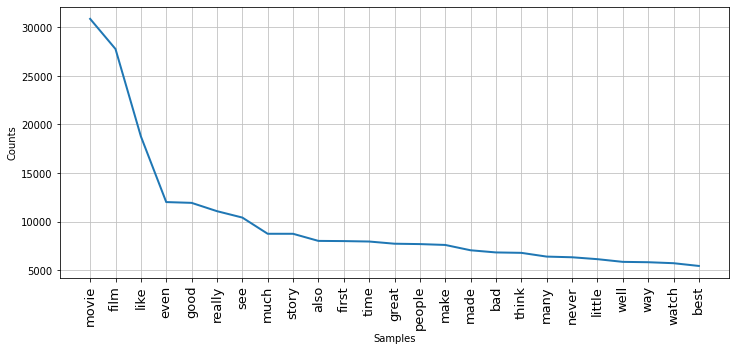

In [23]:
# most common words in twitter dataset 
all_texts = []
for line in list(train['text']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_texts)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_texts).values(), reverse=True)


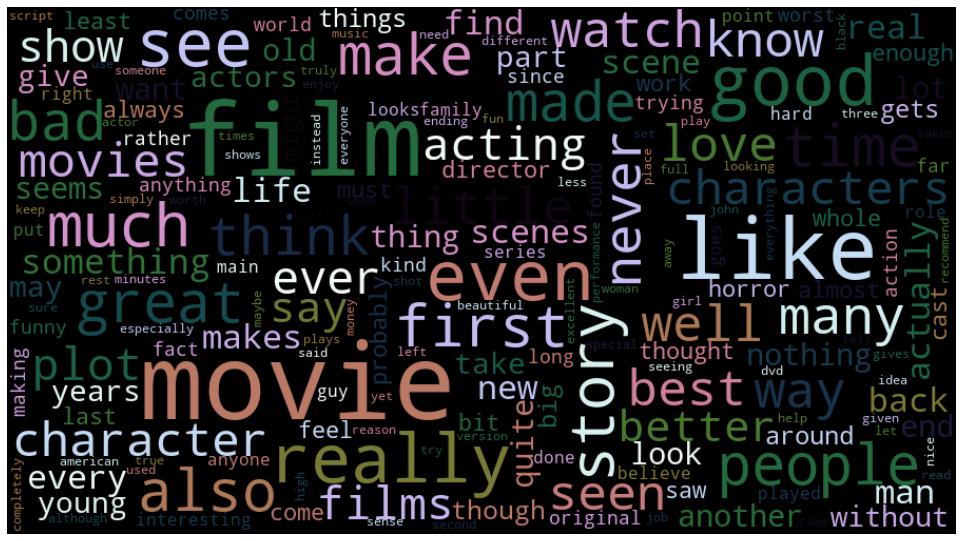

In [24]:
# create a word frequency dictionary
wordfreq = Counter(all_texts)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
print(all_texts[:30])

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'maureen', 'stapleton', 'scene', 'moroni', 'character', 'absolute', 'watch', 'alan', 'hale', 'police', 'bizarre', 'horror', 'movie', 'filled', 'famous', 'faces', 'stolen']


In [0]:
toBeCleanedNew='[%s]' % ' '.join(map(str, all_texts))#remove all the quation marks and commas. 
#print(toBeCleanedNew)

In [27]:


len(wordfreq)#the whole vocabulary size in train dataset



62615

In [28]:
#You need to install version==0.4.2 to run hugging face tokenizer on kaggle
!pip --no-cache-dir install tokenizers==0.4.2 #you get only a warning, just ignore it

my bert

In [29]:
!pip install bert-for-tf2
!pip install sentencepieces

     |████████████████████████████████| 40kB 3.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=00c272162ebc32f77a00039db72d4fafe7a7a95ec8e57fac030801964c4c1c59
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=b7a8cfc2ed79a09b71ac3de6747651a0e62c31802b6eec40bb292ff8b09b67bb
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=16f4642882dc4eb093ad9232c4bb1921abc2a8d331e0ba31e39c0a322ea9187c
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
ERROR: Could not find a version that satisfies the requirement sentencepieces (from versio

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert



import pandas as pd
import numpy as np


In [0]:
y = train['sentiment']

y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)
#tokenizer

angain - trck

In [36]:
#let's try to tokenize the first sentence
#output = tokenizer.encode("deeds reason earthquake may allah forgive")


tokenizer.tokenize("deeds reason earthquake may allah forgive")
#encode ->  tokenize 


['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive']

In [37]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("deeds reason earthquake may allah forgive"))
#ids ->  convert_tokens_to_ids
#output.ids

[15616, 3114, 8372, 2089, 16455, 9641]

In [0]:
#output.offsets
#tokenizer.convert_tokens_to_offsets(tokenizer.tokenize("deeds reason earthquake may allah forgive"))

In [54]:


#convert it back :)
#decode=tokenizer.decode([119, 2281, 1940, 1002, 352, 3542, 9179])
decode=tokenizer.convert_ids_to_tokens([15616, 3114, 8372, 2089, 16455, 9641])
print(decode)



['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive']


again to mine

In [0]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))



In [0]:
reviews = train['text']
tokenized_reviews = [tokenize_reviews(review) for review in reviews]



In [0]:
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]



In [0]:


import random
random.shuffle(reviews_with_len)



In [0]:

reviews_with_len.sort(key=lambda x: x[2])



In [0]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [0]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))


In [0]:


BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))



In [51]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 9), dtype=int32, numpy=
 array([[    0,     0,     0,     0,     0,     0,     0,     0,     0],
        [26232,     0,     0,     0,     0,     0,     0,     0,     0],
        [26232,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 3185,  6659,  2204,     0,     0,     0,     0,     0,     0],
        [ 9278,  2130,  7922, 12635,     0,     0,     0,     0,     0],
        [ 7615,  3185,  2919,  7613,     0,     0,     0,     0,     0],
        [ 2196,  5580,  2156,  4566,  6495,     0,     0,     0,     0],
        [ 2464,  5760,  2387,  2086, 14180,     0,     0,     0,     0],
        [ 2488,  5454,  2703,  2130,  3427,     0,     0,     0,     0],
        [ 2371,  3666,  9735, 14888,  2521,  2126,     0,     0,     0],
        [ 2113,  2066,  3185,  2196,  5458,  3666,     0,     0,     0],
        [ 3185,  2467,  5934,  3185,  2146,  2111,     0,     0,     0],
        [ 8235,  9254,  2919,  3092,  4741,  2086,     0,     0,     0],
   

In [0]:


import math
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)



return to it

In [0]:
# As we don't have label for test dataset, I will split train dataset as trainsub and testsub dataset.
from sklearn.model_selection import train_test_split
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(
  train['text'],train['sentiment'], test_size=0.2, random_state=42)

In [57]:
X_subtrain.head()


14030    hard praise film cgi dragon well lacked proper...
8829     personally film goes top four james cameron pr...
4013     bonanza great cast wonderful lorne pernell mic...
18961    real plot speak excuse show scenes extreme vio...
695      hard believe negative comments regarding laugh...
Name: text, dtype: object

In [58]:
X_subtest.head()

19535    thing frequently pops head writing review neve...
19354    actually pretty bad ideology perverse films co...
6482     night listener robin toni bobby rory joe sandr...
22461    big fan pacino actors movie whole lot better e...
22110    well thank much disney destroying fond memorie...
Name: text, dtype: object

In [59]:
y_subtrain.head()

14030    1
8829     0
4013     0
18961    1
695      0
Name: sentiment, dtype: int64

In [0]:
# import trained corpus to tokenize our dataframe

from tokenizers.implementations import SentencePieceBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer =SentencePieceBPETokenizer(
    '/kaggle/working/tokenedText-vocab.json',
    '/kaggle/working/tokenedText-merges.txt', 
)
tokenizer._tokenizer.post_processor = BertProcessing(
   ("</s>", tokenizer.token_to_id("</s>")),
  ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

X_subtrain_tokened=X_subtrain.apply(lambda x:tokenizer.encode(x).ids)
X_subtrain_tokened.head()
#X_subtrain_tokened



In [0]:

X_subtrain_tokened = [tokenize_reviews(review) for review in X_subtrain]



In [67]:
X_subtrain_tokened=X_subtrain.apply(lambda x:tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))
X_subtrain_tokened.head()

#X_subtrain_tokened=X_subtrain.apply(lambda x:tokenizer.encode(x).ids)
#X_subtrain_tokened.head()

14030    [2524, 8489, 2143, 1039, 5856, 5202, 2092, 108...
8829     [7714, 2143, 3632, 2327, 2176, 2508, 7232, 492...
4013     [14753, 16076, 2307, 3459, 6919, 8840, 12119, ...
18961    [2613, 5436, 3713, 8016, 2265, 5019, 6034, 480...
695      [2524, 2903, 4997, 7928, 4953, 4191, 2972, 297...
Name: text, dtype: object

In [75]:
#X_subtest_tokened=X_subtest.apply(lambda x:tokenizer.encode(x).ids)
#X_subtest_tokened.head()
X_subtest_tokened=X_subtest.apply(lambda x:tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))
X_subtest_tokened.head()

19535    [2518, 4703, 16949, 2132, 3015, 3319, 2196, 31...
19354    [2941, 3492, 2919, 13165, 2566, 16070, 3152, 6...
6482     [2305, 19373, 5863, 16525, 6173, 14285, 3533, ...
22461    [2502, 5470, 14397, 5740, 5889, 3185, 2878, 28...
22110    [2092, 4067, 2172, 6373, 9846, 13545, 5758, 21...
Name: text, dtype: object

In [76]:
y_subtrain.head()

14030    1
8829     0
4013     0
18961    1
695      0
Name: sentiment, dtype: int64

In [77]:
y_subtest.head()

19535    1
19354    1
6482     0
22461    1
22110    1
Name: sentiment, dtype: int64

In [78]:
# the original test dataset (without label)
#test["Tokened_Text"]=test["text"].apply(lambda x:tokenizer.encode(x).ids)
#test.head()
test["Tokened_Text"]=test["text"].apply(lambda x:tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))
test.head()

,text,Tokened_Text
0,movie gets respect sure lot memorable quotes l...,"[3185, 4152, 4847, 2469, 2843, 13432, 16614, 3..."
1,bizarre horror movie filled famous faces stole...,"[13576, 5469, 3185, 3561, 3297, 5344, 7376, 22..."
2,unremarkable favorite thing make way see wonde...,"[4895, 28578, 17007, 3085, 5440, 2518, 2191, 2..."
3,strange feeling sit alone theater occupied par...,"[4326, 3110, 4133, 2894, 4258, 4548, 3008, 489..."
4,probably already know additional episodes neve...,"[2763, 2525, 2113, 3176, 4178, 2196, 4836, 702..."


In [79]:


#check Vocabulary (VOCAB_SIZE) in test dataset
from collections import Counter
subtrain_tokened=[]
for i in X_subtrain_tokened:
    subtrain_tokened+=i
print("Total amount of tokens in train dataset is:", len(subtrain_tokened))
distinct_list= (Counter(subtrain_tokened).keys())
print("The vocabulary size in subtrain dataset is :",len(distinct_list))



Total amount of tokens in train dataset is: 1966326
The vocabulary size in subtrain dataset is : 23928


In [80]:
#print(distinct_list)
print(max(distinct_list))

29611


In [81]:
#check Vocabulary (VOCAB_SIZE) in test dataset
subtest_tokened=[]
for i in X_subtest_tokened:
    subtest_tokened+=i
print("Total amount of tokens in train dataset is:", len(subtest_tokened))
distinct_list_2= (Counter(subtest_tokened).keys())
print("The vocabulary size in subtrain dataset is :",len(distinct_list_2))


Total amount of tokens in train dataset is: 497758
The vocabulary size in subtrain dataset is : 19950


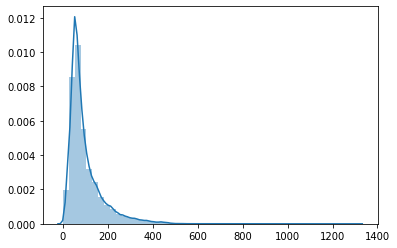

In [82]:
# length distribution in tokened subtrain dataset
subtrain_length_dist=[]
i=0
for l in X_subtrain_tokened:
    subtrain_length_dist+=[len(l)]
y = np.array(subtrain_length_dist)
sns.distplot(y);

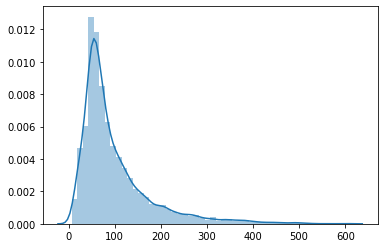

In [83]:
# length distribution in tokened subtest dataset
subtest_length_dist=[]
i=0
for l in X_subtest_tokened:
    subtest_length_dist+=[len(l)]
y = np.array(subtest_length_dist)
sns.distplot(y);


In [84]:
X_subtrain.head()
X_subtrain_tokened.head()

14030    [2524, 8489, 2143, 1039, 5856, 5202, 2092, 108...
8829     [7714, 2143, 3632, 2327, 2176, 2508, 7232, 492...
4013     [14753, 16076, 2307, 3459, 6919, 8840, 12119, ...
18961    [2613, 5436, 3713, 8016, 2265, 5019, 6034, 480...
695      [2524, 2903, 4997, 7928, 4953, 4191, 2972, 297...
Name: text, dtype: object

In [85]:
import keras
max_len=30
x_train = keras.preprocessing.sequence.pad_sequences(X_subtrain_tokened, maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(X_subtest_tokened, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


x_train shape: (20004, 30)
x_test shape: (5001, 30)


In [89]:
import tensorflow as tf
embedding_dim=128
vocab_size=29615
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()#

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 128)           3790720   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 64)            41216     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 32)            10368     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [0]:
y_train=y_subtrain
y_test=y_subtest

In [91]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import datetime
from tensorflow.python.keras.callbacks import TensorBoard

logs_base_dir = "./logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)
history=model.fit(x_train, y_train,
          batch_size=12,
          epochs=2,
          validation_data=[x_test, y_test]) 

Epoch 1/2
1667/1667 [==============================] - 92s 55ms/step - loss: 0.4917 - accuracy: 0.7648 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
1667/1667 [==============================] - 91s 55ms/step - loss: 0.2865 - accuracy: 0.8823 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [0]:
y_train=y_subtrain
y_test=y_subtest

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import datetime
from tensorflow.python.keras.callbacks import TensorBoard

logs_base_dir = "./logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)
history=model.fit(x_train, y_train,
          batch_size=12,
          epochs=20,
          validation_data=[x_test, y_test]) 


Epoch 1/20
1667/1667 [==============================] - 93s 56ms/step - loss: 0.1452 - accuracy: 0.9476 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
1667/1667 [==============================] - 92s 55ms/step - loss: 0.0663 - accuracy: 0.9771 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
1667/1667 [==============================] - 93s 56ms/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
 500/1667 [=======>......................] - ETA: 1:01 - loss: 0.0144 - accuracy: 0.9960

In [0]:
test=keras.preprocessing.sequence.pad_sequences(test['Tokened_Text'], maxlen=max_len)
test.shape

In [0]:
submission=pd.read_csv('/content/drive/My Drive/malia/test.csv')

In [0]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
submission=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pre})
submission.to_csv('submission.csv',index=False)


In [0]:


submission.head()

